# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [93]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 128

### Loading (augmented) metadata as test, train, validation from files

In [94]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path
2762,HAM_0000593,ISIC_0031401.jpg,mel,histo,50.0,male,back,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0031401.jpg
2811,HAM_0002952,ISIC_0033518.jpg,mel,histo,80.0,male,upper extremity,vidir_modern,skin_cancer,malignant,./../data/jpgs/ISIC_0033518.jpg
4306,HAM_0001249,aug_YkkKMhISIC_0033817.jpg,vasc,consensus,85.0,male,back,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_YkkKMhISIC_0033817.jpg
3835,HAM_0005270,ISIC_0032270.jpg,vasc,histo,70.0,female,lower extremity,vienna_dias,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0032270.jpg
4927,HAM_0007227,aug_ixq7x2ISIC_0024973.jpg,df,histo,75.0,male,lower extremity,rosendahl,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_ixq7x2ISIC_0024973.jpg
4205,HAM_0004877,aug_LyErwwISIC_0027159.jpg,vasc,histo,85.0,female,upper extremity,rosendahl,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_LyErwwISIC_0027159.jpg
2067,HAM_0006301,aug_pdSAOjISIC_0024468.jpg,akiec,histo,75.0,male,neck,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_pdSAOjISIC_0024468.jpg
3624,HAM_0005509,aug_mfBjLiISIC_0031057.jpg,bcc,histo,70.0,female,upper extremity,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_mfBjLiISIC_0031057.jpg
2009,HAM_0004060,aug_G2x00jISIC_0030825.jpg,akiec,histo,40.0,male,face,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_G2x00jISIC_0030825.jpg
4407,HAM_0000494,aug_MpWi5LISIC_0033092.jpg,vasc,histo,55.0,male,lower extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_MpWi5LISIC_0033092.jpg


## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [95]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [96]:
"""# Augmentation parameters for Randomsearch
horizontal_flip = hp.Boolean("horizontal_flip")
vertical_flip = hp.Boolean("vertical_flip")
zoom_range = hp.Float("zoom_range", min_value=0.0, max_value=0.5)
width_shift_range = hp.Float("width_shift_range", min_value=0.0, max_value=0.5)
height_shift_range = hp.Float("height_shift_range", min_value=0.0, max_value=0.5)
rotation_range = hp.Int("rotation_range", min_value=0, max_value=180)
shear_range = hp.Float("shear_range", min_value=0.0, max_value=0.5)
"""

# Setting up the Image Data Generator for the train and validation data set
datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.


In [97]:
validation_generator

In [98]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [99]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


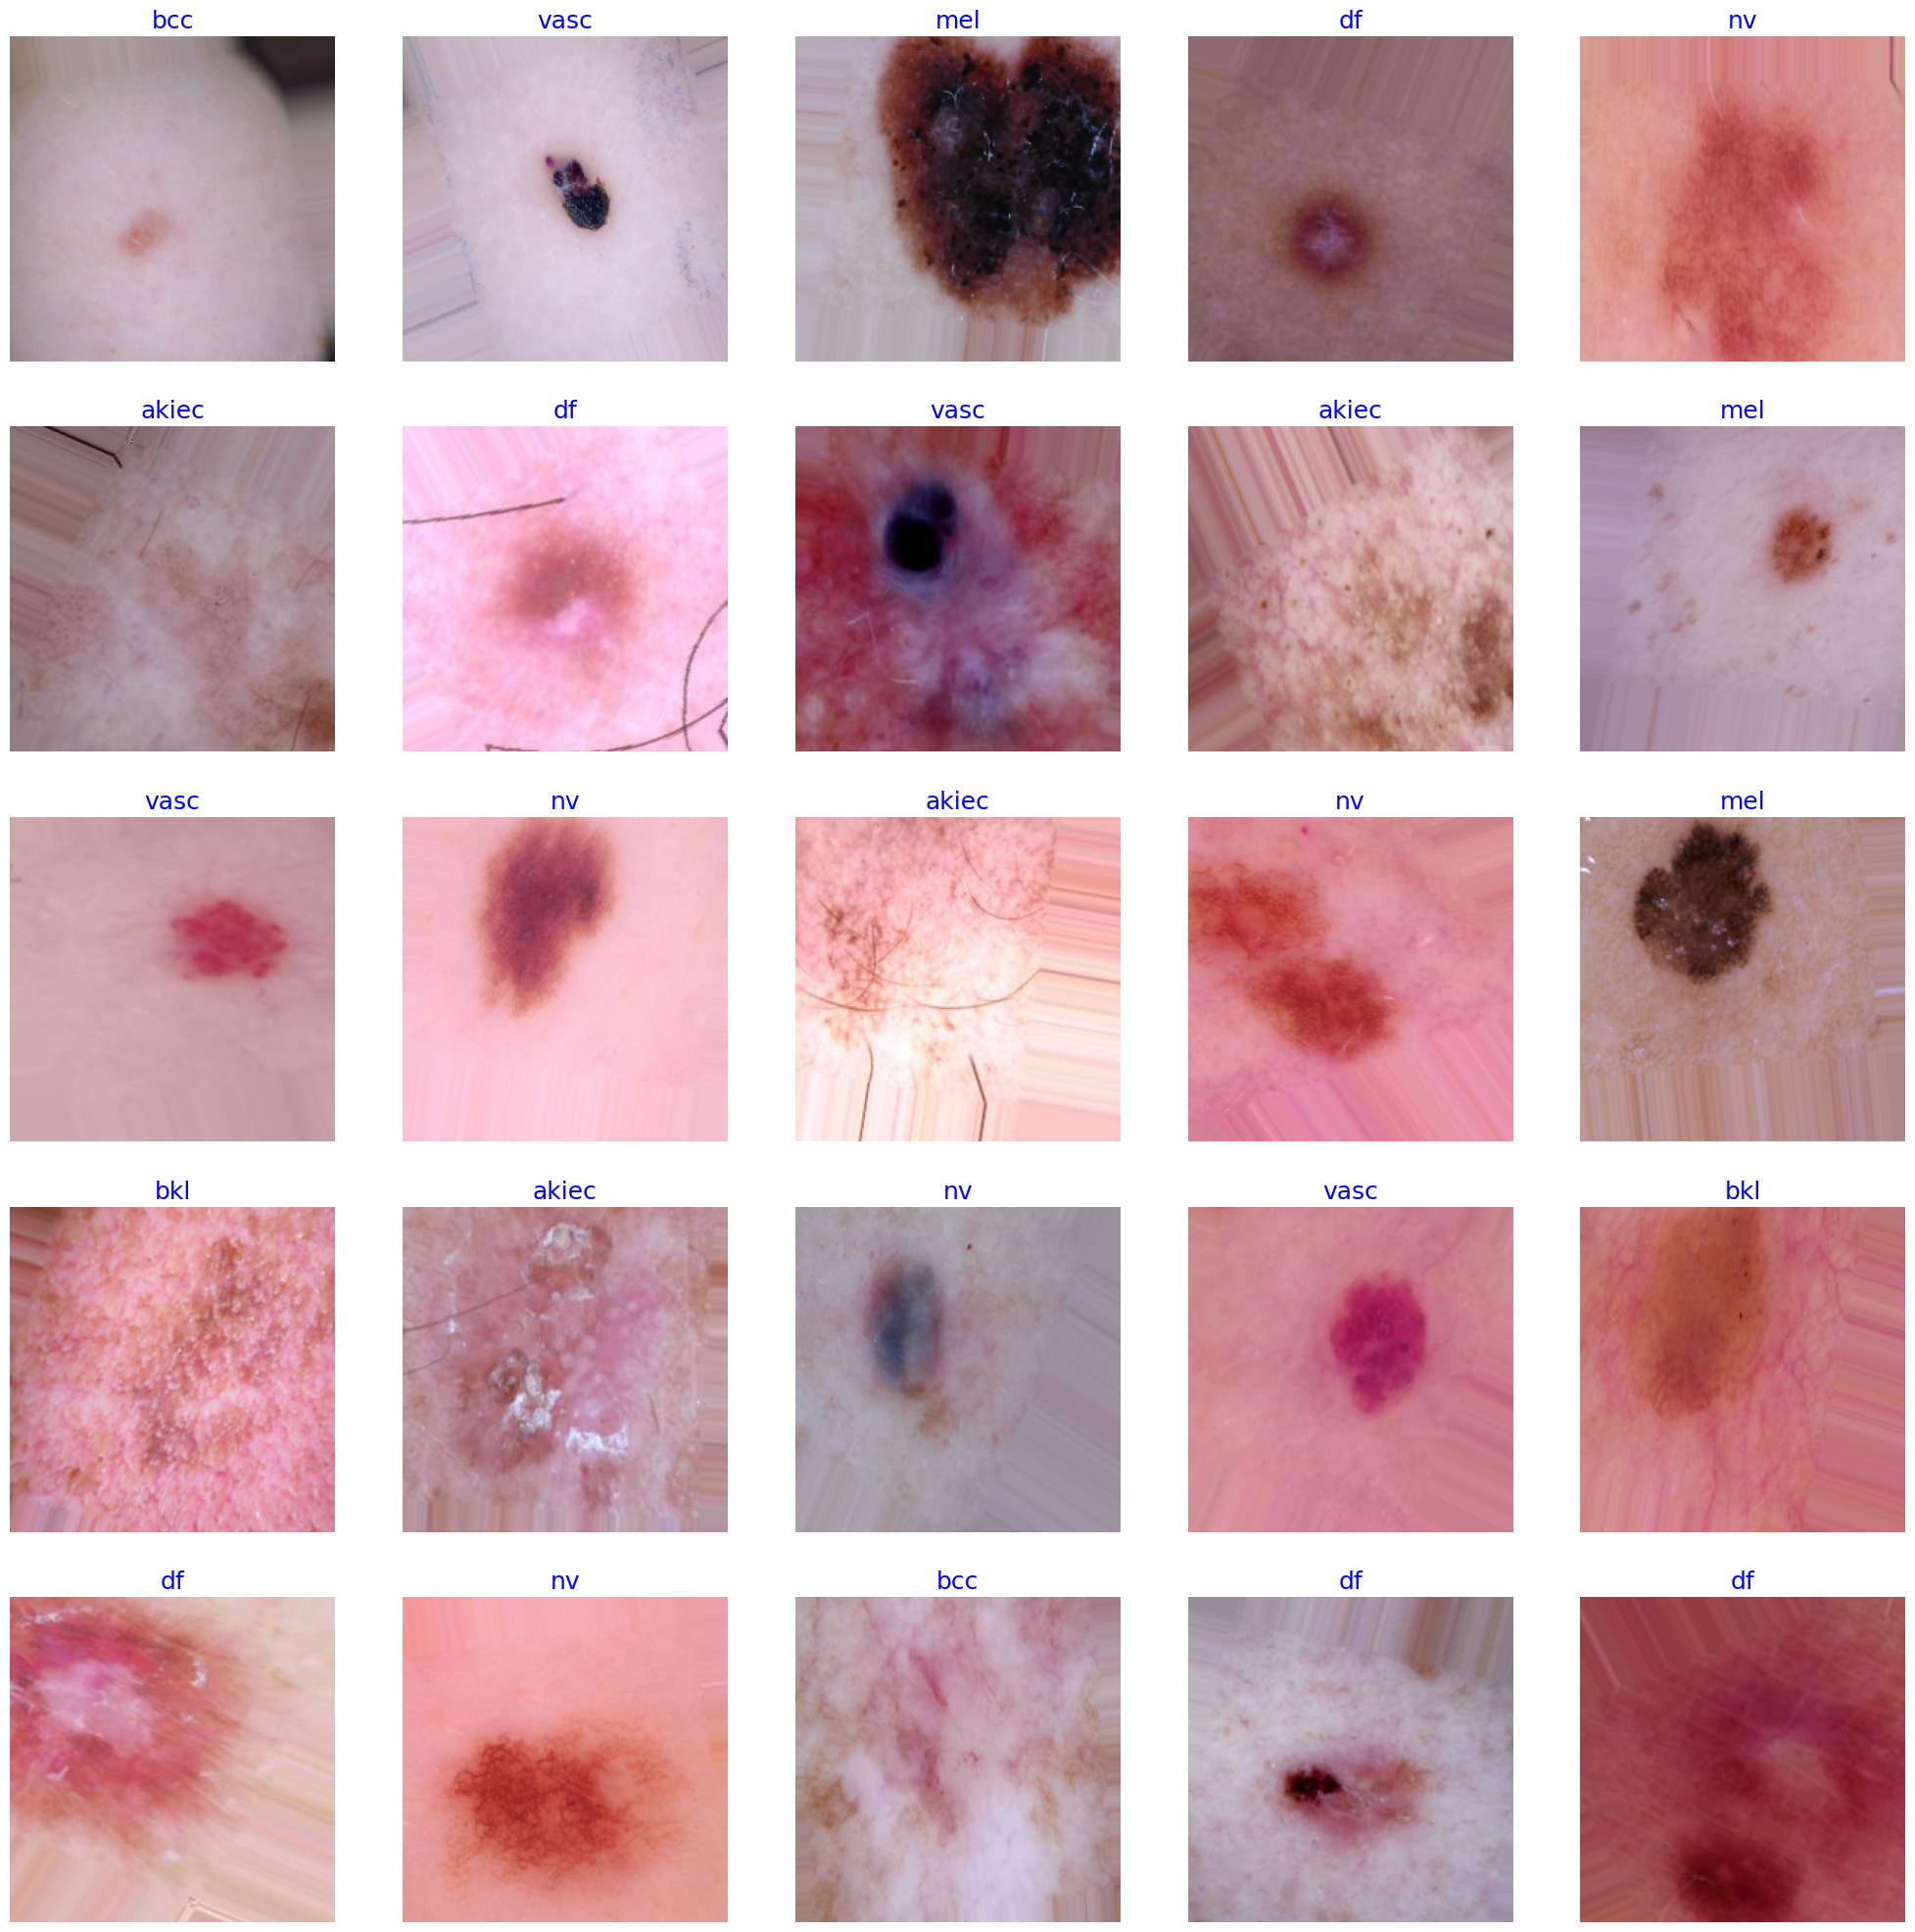

In [100]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [101]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [102]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

## Model architecture

In [109]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine import hyperparameters
import math
import tensorflow as tf
from sklearn.utils import class_weight
import os

### Schnelles und simples Modell zum ersten Versuch

In [103]:


def build_simple_model():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    # (Unverändert, da dies notwendig ist, um die Anzahl der Klassen zu wissen)
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze layers in the base model
    # (Geändert: Wir frieren alle Schichten ein, um das Training zu beschleunigen)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers for classification
    x = base_model.output
    
    # (Geändert: Kein Conv2D Layer, da wir ein schnelleres Modell wollen)
    x = GlobalAveragePooling2D()(x)
    
    # (Geändert: Reduzierte Anzahl von Neuronen auf 128 für Schnelligkeit)
    x = Dense(128, activation='relu')(x)
    
    # (Geändert: Kein Dropout, um das Modell schneller zu machen)
    
    # (Unverändert: Softmax für Multiklassen-Klassifikation)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    # (Unverändert: Wir brauchen diese Zeile, um das Modell zu erstellen)
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    # (Geändert: Einfacher Adam Optimizer und nur 'accuracy' als Metrik)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model


### Callback functions

#### Learning rate scheduler for model compilation

In [104]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Class weights 

In [105]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.999429332318813,
 1: 0.999429332318813,
 2: 1.0007619047619047,
 3: 0.999429332318813,
 4: 1.0007619047619047,
 5: 1.0007619047619047,
 6: 0.999429332318813}

#### Early stopping

In [106]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_f1_score',  # Metric to monitor for early stopping
    patience=5,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

#### Random Search tuner for hyhperparameter tuning

In [ ]:
 # Create a RandomSearch tuner
tuner = RandomSearch(
    model,
    objective='val_accuracy',
    max_trials=5,  # Reduced number of trials for a quicker search
    directory='random_search',  # Directory to save results
    project_name='cnn_hyperparameter_tuning'  # Name of the project
)

# Search for the best hyperparameters
tuner.search(
    train_data_generator,
    epochs=3,  # Reduced number of epochs for a quicker search
    validation_data=validation_generator,
    # Removed callbacks and class_weights for a quicker search
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model directly from the tuner
best_models = tuner.get_best_models(num_models=1)

# Build the final model using the best model
final_model = best_models[0]

## Model Training

In [107]:
model = build_simple_model()  # Baut das einfache Modell
NUM_EPOCHS = 5  # Zum Beispiel, für ein schnelles Training

# Trainiere das Modell
history = model.fit(
    train_data_generator,  # Trainingsdaten
    epochs=NUM_EPOCHS,  # Anzahl der Epochen
    validation_data=validation_generator,  # Validierungsdaten
    verbose=1  # Ausgabe des Trainingsfortschritts
)


Epoch 1/5


2023-10-09 13:37:05.343978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 2.0052 - accuracy: 0.1332 - f1_score: 0.0000e+00

2023-10-09 13:38:48.378482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 133s 3s/step - loss: 2.0052 - accuracy: 0.1332 - f1_score: 0.0000e+00 - val_loss: 1.7885 - val_accuracy: 0.6623 - val_f1_score: 0.0000e+00
Epoch 2/5
42/42 [==============================] - 111s 3s/step - loss: 1.9698 - accuracy: 0.1452 - f1_score: 0.0000e+00 - val_loss: 2.0182 - val_accuracy: 0.0110 - val_f1_score: 0.0000e+00
Epoch 3/5
42/42 [==============================] - 109s 3s/step - loss: 1.9729 - accuracy: 0.1448 - f1_score: 0.0000e+00 - val_loss: 1.9998 - val_accuracy: 0.0190 - val_f1_score: 0.0000e+00
Epoch 4/5
42/42 [==============================] - 115s 3s/step - loss: 1.9529 - accuracy: 0.1431 - f1_score: 0.0000e+00 - val_loss: 1.8991 - val_accuracy: 0.1638 - val_f1_score: 0.0000e+00
Epoch 5/5
42/42 [==============================] - 119s 3s/step - loss: 1.9544 - accuracy: 0.1473 - f1_score: 0.0000e+00 - val_loss: 1.9679 - val_accuracy: 0.0210 - val_f1_score: 0.0000e+00


## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

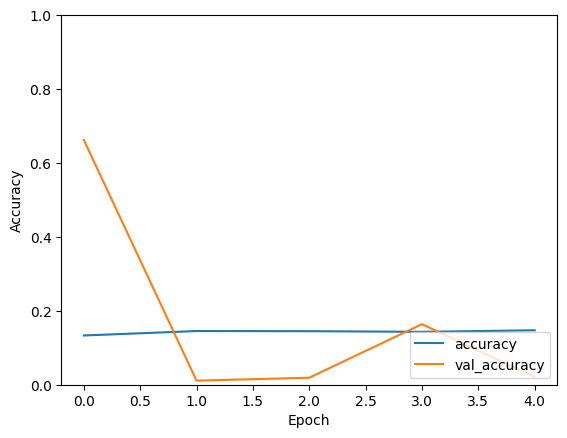

In [108]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
# Save the final model
final_model.save('best_hyperparameters_first_try.h5')

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)